## Overview
This notebook is classifier is a sign language classifier using Deep Learning Techniques implemented in the Tensorflow framework.
The training as well as testing datasets can be found through the data science platform [Kaggle Platform](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) 

In [172]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [173]:
main_directory = os.path.join("datasets", "Sign_language_MNIST") # the root directory for the data (Please change it accordingly)

### Setting the directories 
The dataset is provided in a zip file. The datatsets are extracted. I decided to automate the process with Python in the few next cells.

In [174]:
import zipfile
initial_archive_name = "archive.zip"
archive_zip = os.path.join(main_directory, initial_archive_name)
if os.path.exists(archive_zip):
    zip_ref = zipfile.ZipFile(archive_zip, 'r')
    zip_ref.extractall(main_directory)
    zip_ref.close()

In [175]:
print(os.listdir(main_directory))   
TRAINING_DIR_NAME = "sign_mnist_train"
TESTING_DIR_NAME = "sign_mnist_test"

['amer_sign2.png', 'american_sign_language.PNG', 'sign_mnist_train', 'amer_sign3.png', 'sign_mnist_test']


### Working with the training files
After removing the unnecessary directories, it is time to understand the data provided and perform the necessary data preprocessing before creating any model.

In [176]:
TRAIN_DIR = os.path.join(main_directory, TRAINING_DIR_NAME)
TEST_DIR = os.path.join(main_directory, TESTING_DIR_NAME)

In [177]:
# print the content of the training diretory
print(os.listdir(TRAIN_DIR))
print(os.listdir(TEST_DIR))

['sign_mnist_train.csv']
['sign_mnist_test.csv']


In [178]:
## the data is stored in a csv which requires the use of the pandas library
import pandas as pd
train_file = os.path.join(TRAIN_DIR, os.listdir(TRAIN_DIR)[0])
train_df_org = pd.read_csv(train_file) 

test_file = os.path.join(TEST_DIR, os.listdir(TEST_DIR)[0])
test_df_org = pd.read_csv(test_file)

In [179]:
print(train_df_org.shape)
# so we can see we have 785 columns and 27455 training samples
print(train_df_org.columns)
# as we can see the first picture is the label while the rest represent numerical values of the individual pixels

new_cols_name = {}
new_cols_name['label'] = "y"
for i in range(1, 785):
    new_cols_name["pixel{}".format(str(i))] = str(i)
train_df = train_df_org.rename(columns=new_cols_name)
test_df = test_df_org.rename(columns=new_cols_name)

(27455, 785)
Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)


In [180]:
y_train = train_df["y"]
train_df.drop("y", inplace=True,axis=1)

y_test = test_df["y"]
test_df.drop("y", inplace=True,axis=1)

In [181]:
img_size = (28, 28, 1)

In [182]:
# according to the data documentation, the images are meant to be 28 * 28 gray scale images
pixel_range = 255.0
def transform_row_to_pic(df, index):
    return df.iloc[i, :].values.reshape(img_size) / pixel_range

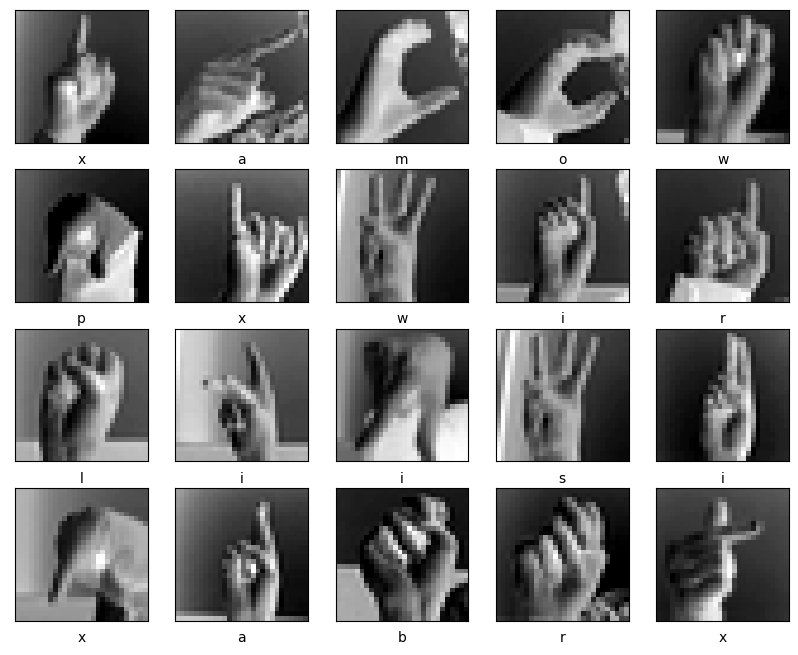

In [183]:
import string
import random
sample = 20
## Visualize a random smaple of the training dataset 

plt.figure(figsize=(10, 10))
for i in range(sample):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = random.randint(0, len(train_df))
    plt.imshow(transform_row_to_pic(train_df, index), cmap=plt.cm.binary)
    plt.xlabel(string.ascii_letters[y_train[index]]) # the numerical label associated with the hand sign is the letter's order in the alphabet

plt.show()

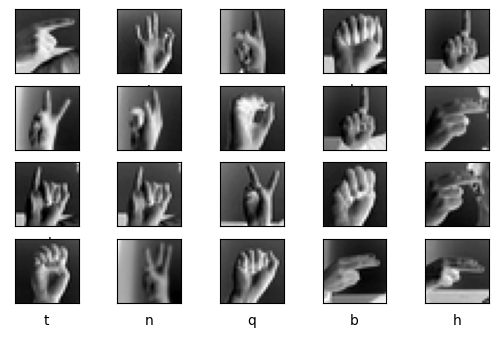

In [184]:
# visualize a random sample of the test dataset.
for i in range(sample):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = random.randint(0, len(test_df))
    plt.imshow(transform_row_to_pic(test_df, index), cmap=plt.cm.binary)
    plt.xlabel(string.ascii_letters[(y_test[index])]) # the numerical label associated with the hand sign is the letter's order in the alphabet

plt.show()

In [185]:
def df_to_X(df):
    """This method coverts the training dataframe to a numpy array"""
    return np.array([df.iloc[i, :].values / pixel_range for i in range(len(df))])

In [186]:
X_train = df_to_X(train_df)
Y_train = y_train.values

X_test = df_to_X(test_df)
Y_test = y_test.values

In [187]:
## use a validation dataset to better evaluate the model
from sklearn.model_selection import train_test_split
val_size = 0.2
random_state = 11
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size, random_state=random_state) 

In [188]:
X_train_img = np.array([np.reshape(row,(28, 28, 1)) for row in X_train]) # the data should be reshaped before being augmented.
X_val_img = np.array([np.reshape(row,(28, 28, 1)) for row in X_val]) # save an image version of the cross validation dataset
X_test_img = np.array([np.reshape(row,(28, 28, 1)) for row in X_test])

In [189]:
# DL models imports
import tensorflow as tf
import tensorflow.keras.layers as tfl

### Data Augmentation
The training data provided is relatively large. However, we might try to augment the data to obtain more diversity and possibly achieve  
better performance.

In [190]:
from tensorflow.image import flip_left_right
from tensorflow.image import central_crop
from tensorflow.image import resize

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def augmented_image(image, t=0.5, central_frac=0.8, res=True):
    p = random.random()
    new_image = None
    if p > t:
        new_image =  central_crop(image, central_fraction=0.8)
    else:
        new_image = flip_left_right(image)
    if res:
        return resize(new_image, [image.shape[0], image.shape[1]], method="nearest")
    return new_image


In [191]:
# saving the augmented images as arrays
X_train_aug = np.array([augmented_image(image).reshape((-1, )) for image in X_train_img])
# saving the augmented images as images (3 dimensional np arrays)
X_train_aug_img = np.array([image.reshape(28, 28, 1) for image in X_train_aug])

In [192]:
print(X_train_aug.shape)
print(X_train.shape)

(21964, 784)
(21964, 784)


In [193]:
# choose a random slice of the augmented dataset to add to the original one.
start_index = np.random.randint(0, len(X_train_aug) / 2)
number_augmented = np.random.randint(0, len(X_train_aug) / 2)
X_train_final = np.append(X_train,X_train_aug[start_index: start_index + number_augmented] , axis=0) 
Y_train_final = np.append(Y_train, Y_train[start_index: start_index + number_augmented], axis=0)

## Models
In this part of the notebook, I will experiment with different models starting with Plain Neural Networks to CNN based on transfer learning.

### Plain Neural Networks 
So the first approach to solve this problem is to use Plain neural networks that uses all of the bytes in each picture. The main goal is to achieve as high of a performance as possible with each available model.

In [194]:
# build the model: 
#input_shape = (1, 784)
first_model = tf.keras.Sequential([
    # tfl.Flatten(input_shape=input_shape),  # this layer is not needed as the data is already provided in a numpy array form
    tfl.Dense(1024, activation='relu'), 
    tfl.Dense(1024, activation='relu'), 
    tfl.BatchNormalization(), 
    tfl.Dense(512, activation='relu'), 
    tfl.Dense(512, activation='relu'),
    tfl.BatchNormalization(),
    tfl.Dense(256, activation='relu'), 
    tfl.Dense(128, activation='relu'),
    tfl.BatchNormalization(),
    tfl.Dense(64, activation='relu'),
    tfl.Dense(32, activation='relu'), 
    tfl.BatchNormalization(),  
    tfl.Dense(26, activation='softmax')] # output layer
    ) 

# compile the model
EPOCHS = 15

In [195]:
first_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history_aug = first_model.fit(X_train_final, Y_train_final, epochs=EPOCHS, validation_data=(X_val, Y_val))

Epoch 1/15
983/983 [==============================] - 40s 36ms/step - loss: 2.0995 - accuracy: 0.3504 - val_loss: 10.9860 - val_accuracy: 0.0596
Epoch 2/15
983/983 [==============================] - 44s 44ms/step - loss: 1.1392 - accuracy: 0.6312 - val_loss: 1.9994 - val_accuracy: 0.4424
Epoch 3/15
983/983 [==============================] - 33s 33ms/step - loss: 0.6727 - accuracy: 0.7845 - val_loss: 1.3915 - val_accuracy: 0.6143
Epoch 4/15
983/983 [==============================] - 29s 30ms/step - loss: 0.4636 - accuracy: 0.8520 - val_loss: 1.8724 - val_accuracy: 0.5168
Epoch 5/15
983/983 [==============================] - 30s 30ms/step - loss: 0.3446 - accuracy: 0.8923 - val_loss: 1.5229 - val_accuracy: 0.6163
Epoch 6/15
983/983 [==============================] - 28s 29ms/step - loss: 0.2797 - accuracy: 0.9119 - val_loss: 0.8643 - val_accuracy: 0.7407
Epoch 7/15
983/983 [==============================] - 29s 30ms/step - loss: 0.2294 - accuracy: 0.9266 - val_loss: 1.0796 - val_accuracy

In [196]:
print(first_model.evaluate(X_test, Y_test))

225/225 [==============================] - 2s 8ms/step - loss: 2.7575 - accuracy: 0.4979
[2.7574546337127686, 0.4979085326194763]


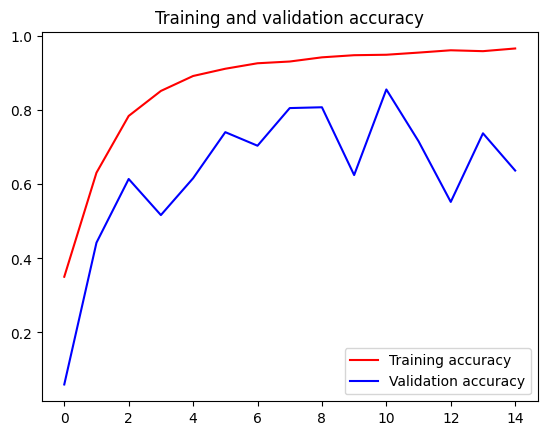

<Figure size 640x480 with 0 Axes>

In [197]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Plain Neural networks are not the most efficient models for computer vision tasks. 
### Convolutional Neural Network
Convolutional neural network represent a more powerful tool as they extract features from the images using filters resulting in a significant improvement in performance while mainting a relatively low number of parameters.

In [198]:
# the model to be trained is the same as the one in the "fashion_classification_CNN.ipynb" notebook

def cnn_model(input_shape=(28, 28, 1), num_classes=10):
    # define the input
    inputs = tf.keras.Input(shape=input_shape)
    # relu activation is used extensively:
    relu = tfl.ReLU()
    # 2D convolutional layer
    f1 = 16
    size1  = (3, 3)
    conv1 = tfl.Conv2D(filters=f1, kernel_size=size1, strides=(2, 2), padding='same')
    
    pool1 = tfl.MaxPool2D((2, 2))
    f2 = 32
    conv2 = tfl.Conv2D(filters=f2, kernel_size=size1, strides=(1, 1), padding='same')
    
    size2 = (3, 3)
    f3 = 64
    conv3 = tfl.Conv2D(filters=f3, kernel_size=size2, strides=(2, 2), padding='same')

    f4 = 64
    conv4 = tfl.Conv2D(filters=f4, kernel_size=size2, strides=(1, 1), padding='same')

    pool2 = tfl.MaxPool2D((2, 2))

    # the neural network should be as follows:
    # con1 * 2 -> conv2 *2 -> pool1 -> conv3 * 2 -> conv4 * 2 -> pool2 -> fully connected1 -> fullyconnected2 -> softmax
    x = conv1(inputs)
    x = relu(x)

    x = conv2(inputs)
    x = relu(x)
    
    # normalizing on the channel axis
    x = tfl.BatchNormalization(axis=-1)(x)
    x = pool1(x)
    
    x = conv3(x)
    x = relu(x)

    x = conv4(x)
    x = relu(x)

    # normalizing on the channel axis
    x = tfl.BatchNormalization(axis=-1)(x)
    x = pool2(x)

    flatten = tfl.Flatten() 
    fc1 = tfl.Dense(128, activation='relu')
    fc2 = tfl.Dense(128, activation='relu')
    if num_classes == 2:
        fc3 = tfl.Dense(1 , activation='sigmoid')
    else:
        fc3 = tfl.Dense(num_classes, activation='softmax')
    x = flatten(x)
    x = fc1(x)
    x = fc2(x)
    outputs = fc3(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [199]:
# using the cnn model would require reshaping the training_data
start_index = np.random.randint(0, len(X_train_aug) / 2)
number_augmented = np.random.randint(0, len(X_train_aug) / 2)
X_train_img_final = np.append(X_train_img, X_train_aug_img[start_index: start_index + number_augmented] , axis=0) 
Y_train_img_final = np.append(Y_train, Y_train[start_index: start_index + number_augmented], axis=0)

In [1]:
print (X_train_img_final.shape)
print(Y_train_img_final.shape)

NameError: name 'X_train_img_final' is not defined

In [201]:
cnnModel = cnn_model(input_shape=(28, 28, 1), num_classes=26)
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']
cnnModel.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
num_batches = 20
num_epochs = 12
batch_size = (X_train_img_final.shape[0] // num_batches)
print(batch_size)
cnnModel.fit(X_train_img_final, Y_train_img_final, epochs=num_epochs, 
             batch_size=batch_size)

In [ ]:
# def dnn_with_dropout():
#     model = tf.keras.Sequential([
#     tfl.Dense(1024, activation='relu'),
#     tfl.Dropout(0.4),
    
#     tfl.Dense(1024, activation='relu'),
#     tfl.BatchNormalization(axis=-1), 
#     tfl.Dropout(0.4),

#     tfl.Dense(512, activation='relu'),
#     tfl.Dropout(0.2),

#     tfl.Dense(512, activation='relu'),
#     tfl.BatchNormalization(axis=-1), 
#     tfl.Dropout(0.2),
    
#     tfl.Dense(256, activation='relu'),
#     tfl.Dropout(0.1),
    
#     tfl.Dense(128, activation='relu'),
#     tfl.BatchNormalization(axis=-1),
#     tfl.Dropout(0.05),

#     tfl.Dense(64, activation='relu'),    
#     tfl.Dense(26, activation='softmax')]) # output layer
#     return model

IndentationError: unexpected indent (888154713.py, line 2)

In [ ]:
# second_model = dnn_with_dropout()
# second_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
# history_aug = second_model.fit(X_train_final, Y_train_final, epochs=EPOCHS, validation_data=(X_val, Y_val))
# print(second_model.evaluate(X_test, Y_test))


In [ ]:
# def dnn_with_l2(input_shape=(784, )):
    # inputs = tfl.Input(shape=input_shape)
    # X = tfl.Dense(1024, activation='relu', kernel_regularizer='l2')(inputs)
    # X = tfl.Dense(1024, activation='relu', kernel_regularizer='l2')(X) 
    # X = tfl.BatchNormalization(axis=-1)(X) 
    # X = tfl.Dense(512, activation='relu', kernel_regularizer='l2')(X)

    # X = tfl.Dense(512, activation='relu', kernel_regularizer='l2')(X)
    # X = tfl.BatchNormalization(axis=-1)(X)
    # X = tfl.Dense(256, activation='relu', kernel_regularizer='l2')(X)
    
    # X = tfl.Dense(128, activation='relu', kernel_regularizer='l2')(X)
    # X = tfl.BatchNormalization(axis=-1)(X)
    
    # X = tfl.Dense(64, activation='relu', kernel_regularizer='l2')(X)   
    # outputs = tfl.Dense(26, activation='softmax')(X) # output layer
    
    # return tf.keras.Model(inputs, outputs)    

In [ ]:
# third_model = dnn_with_l2()
# third_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
# third_model.fit(X_train_final, Y_train_final)
# print(third_model.evaluate(X_test, Y_test))